In [1]:
from google.colab import drive
import zipfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Dataset.zip'

# Directory to extract the files to
extracted_dir = '/content/Dataset'

# Create directory if it doesn't exist
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Extraction complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.


In [9]:
!pip install numpy matplotlib scikit-image opencv-python scikit-learn
!pip install opencv-python
!pip install tensorflow


In [10]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, UpSampling2D, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
def load_images_from_directory(directory, max_images=1000):
    images = []
    for filename in sorted(os.listdir(directory))[:max_images]:
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

#Function to preprocess images
def preprocess_images(images, size=(128, 128)):
    processed_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.resize(img, size)  # Resize image
        processed_images.append(img)
    return processed_images

#

In [12]:
def analyze_image_properties(images):
    dimensions= [img.shape for img in images]
    mean_colors=[[img[:, :, i].mean() for i in range(img.shape[-1])] for img in images]
    return dimensions,mean_colors


def plot_color_histograms(images, title):
    colors =('b', 'g', 'r')
    plt.figure(figsize=(5, 3))
    for i, color in enumerate(colors):
        hist=cv2.calcHist([images[0]], [i], None, [256], [0, 256])
        plt.plot(hist,color=color)
        plt.xlim([0,256])
    plt.title(title + ' Color histogram')
    plt.show()

In [13]:
#Paths
base_path = './Dataset'
train_real_path = os.path.join(base_path, 'Train/Real/')
train_fake_path = os.path.join(base_path, 'Train/Fake/')
validation_real_path = os.path.join(base_path, 'Validation/Real/')
validation_fake_path = os.path.join(base_path, 'Validation/Fake/')
test_real_path = os.path.join(base_path, 'Test/Real/')
test_fake_path = os.path.join(base_path, 'Test/Fake/')

In [14]:
real_images = load_images_from_directory(train_real_path, max_images=1000)
fake_images = load_images_from_directory(train_fake_path, max_images=1000)

In [32]:
images_dict={
    "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Fake images\\Fake1":822,
    "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Fake images\\Fake2":893,
    "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Fake images\\Fake3":887,
   "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Real Images\\Real1":56,
  "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Real Images\\Real2":271,
   "C:\\Users\\DELL\\OneDrive\\Desktop\\images_test\\Real Images\\Real3":48,
}

In [15]:
#Getting image properties
real_dims,real_colors =analyze_image_properties(real_images)
fake_dims, fake_colors= analyze_image_properties(fake_images)
print("Real image dimensions:",real_dims)
print("Real image mean colors-BGR:",real_colors)
print("Fake image dimensions:", fake_dims)
print("Fake image mean colors -BGR:",fake_colors)

Real image dimensions: [(256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (

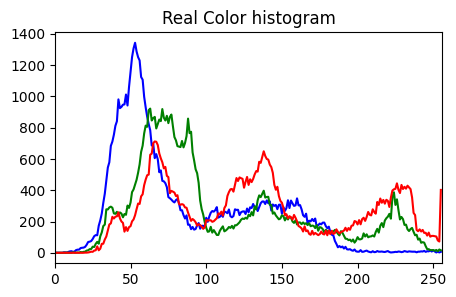

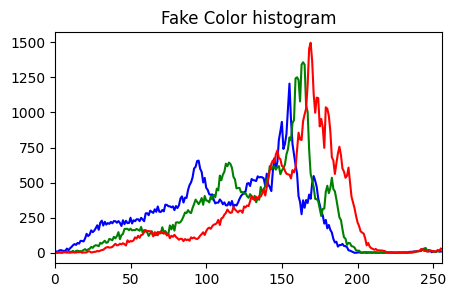

In [16]:
plot_color_histograms(real_images, 'Real')
plot_color_histograms(fake_images,'Fake')

In [17]:
def build_model(input_shape=(128, 128, 3)):
    model=Sequential([
        Conv2D(32, (3,3),activation='relu',input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64,(3, 3),activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128,(3, 3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128,activation='relu'),
        Dropout(0.5),
        Dense(1,activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [18]:
def load_and_preprocess_images(directory, size=(128, 128), max_images=500):
    images = []
    categories = ['Real', 'Fake']
    for folder in categories:
        class_folder = os.path.join(directory, folder)
        if not os.path.exists(class_folder):
            print(f"Directory not found: {class_folder}")
            continue
        image_files = sorted(os.listdir(class_folder))[:max_images]
        for filename in image_files:
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting from BGR to RGB
                img = cv2.resize(img, size)
                images.append(img)
            if len(images) >= max_images * len(categories):
                break
        if len(images) >= max_images * len(categories):
            break
    return np.array(images)

In [19]:
#Paths to folders
base_path ='./Dataset'
train_path=os.path.join(base_path, 'Train')
test_path=os.path.join(base_path, 'Test')
validation_path = os.path.join(base_path, 'Validation')


X_train =load_and_preprocess_images(train_path)
X_test= load_and_preprocess_images(test_path)
X_val=load_and_preprocess_images(validation_path)

In [21]:
#Preparing labels
y_train= np.array([1] * (len(X_train) // 2) + [0] * (len(X_train) // 2))
y_test =np.array([1] * (len(X_test) // 2) + [0] * (len(X_test) // 2))
y_val=np.array([1] * (len(X_val) // 2) + [0] * (len(X_val) // 2))

In [22]:
X_train_full =np.concatenate((X_train,X_test))
y_train_full= np.concatenate((y_train,y_test))

In [25]:
#Building and training the model
model =build_model()
history=model.fit(X_train_full,y_train_full, epochs=20,validation_data=(X_val, y_val))

#Evaluating model on validation set
val_loss,val_acc =model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss},Validation accuracy: {val_acc}")

Epoch 1/20
63/63 [==============================] - 76s 1s/step - loss: 5.3887 - accuracy: 0.6590 - val_loss: 0.7415 - val_accuracy: 0.5810
Epoch 2/20
63/63 [==============================] - 74s 1s/step - loss: 0.5513 - accuracy: 0.7260 - val_loss: 0.7216 - val_accuracy: 0.6400
Epoch 3/20
63/63 [==============================] - 74s 1s/step - loss: 0.4748 - accuracy: 0.7685 - val_loss: 0.7757 - val_accuracy: 0.6310
Epoch 4/20
63/63 [==============================] - 73s 1s/step - loss: 0.4390 - accuracy: 0.8010 - val_loss: 0.7943 - val_accuracy: 0.6460
Epoch 5/20
63/63 [==============================] - 71s 1s/step - loss: 0.4131 - accuracy: 0.8095 - val_loss: 0.7528 - val_accuracy: 0.5990
Epoch 6/20
63/63 [==============================] - 73s 1s/step - loss: 0.3539 - accuracy: 0.8405 - val_loss: 0.9631 - val_accuracy: 0.6290
Epoch 7/20
63/63 [==============================] - 79s 1s/step - loss: 0.3205 - accuracy: 0.8610 - val_loss: 0.9248 - val_accuracy: 0.6380
Epoch 8/20
63/63 [==

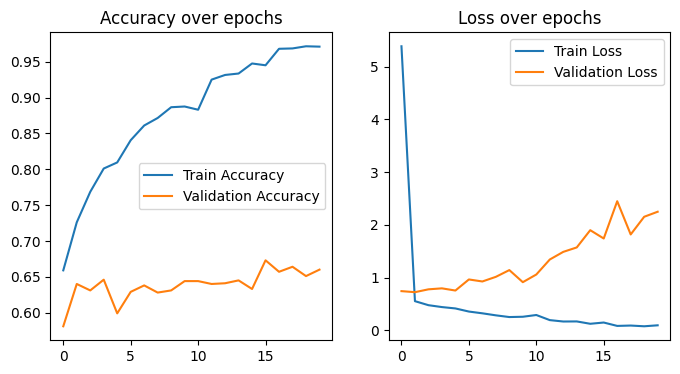

In [26]:
#Plotting training history
plt.figure(figsize=(8, 4))
plt.subplot(1, 2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

Enter path of the image to classify : C:\Users\DELL\OneDrive\Desktop\images_test\Fake images\Fake2
893
1/1 [==============================] - 0s 29ms/step


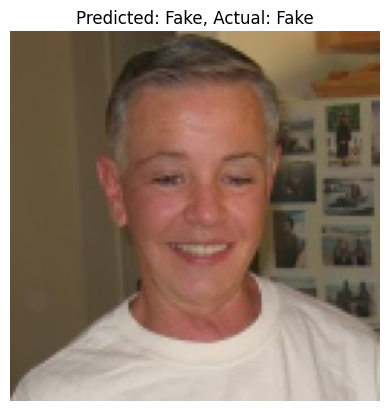

In [33]:
import random

def predict_random_image(model, images, labels):
    paths=input("Enter path of the image to classify : ")
    paths.replace("/","//")
    idx =images_dict[paths]
    image = images[idx]  # Access the image using its index
    print(idx)
    plt.imshow(images[idx])
    true_label = labels[idx]
    label_map = {1: 'Real', 0: 'Fake'}


    image_input = np.expand_dims(image, axis=0)

    prediction = model.predict(image_input)
    predicted_label = (prediction > 0.5).astype(int)


    plt.imshow(image)
    plt.title(f'Predicted: {label_map[predicted_label[0][0]]}, Actual: {label_map[true_label]}')
    plt.axis('off')
    plt.show()
    return model

# Example usage:
predict_random_image(model, X_val, y_val)

#U-net model

In [34]:
def build_unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    bn = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)


    u1 = UpSampling2D((2, 2))(bn)
    merge1 = concatenate([u1, c3])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    u2 = UpSampling2D((2, 2))(c4)
    merge2 = concatenate([u2, c2])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
    u3 = UpSampling2D((2, 2))(c5)
    merge3 = concatenate([u3, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)

    flattened = Flatten()(c6)
    output = Dense(1, activation='sigmoid')(flattened)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [35]:
# Rebuilding the U-Net model
unet_model = build_unet_model()

# Retrain the U-Net model
history_unet = unet_model.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
63/63 [==============================] - 253s 4s/step - loss: 28.7792 - accuracy: 0.5115 - val_loss: 0.6906 - val_accuracy: 0.4980
Epoch 2/10
63/63 [==============================] - 248s 4s/step - loss: 0.6857 - accuracy: 0.5410 - val_loss: 0.6921 - val_accuracy: 0.4970
Epoch 3/10
63/63 [==============================] - 246s 4s/step - loss: 0.6763 - accuracy: 0.5635 - val_loss: 0.7077 - val_accuracy: 0.5540
Epoch 4/10
63/63 [==============================] - 232s 4s/step - loss: 0.6684 - accuracy: 0.5755 - val_loss: 0.7149 - val_accuracy: 0.5380
Epoch 5/10
63/63 [==============================] - 252s 4s/step - loss: 0.6618 - accuracy: 0.5875 - val_loss: 0.7116 - val_accuracy: 0.5200
Epoch 6/10
63/63 [==============================] - 241s 4s/step - loss: 0.6489 - accuracy: 0.6005 - val_loss: 0.7154 - val_accuracy: 0.5380
Epoch 7/10
63/63 [==============================] - 244s 4s/step - loss: 0.6347 - accuracy: 0.6095 - val_loss: 0.7810 - val_accuracy: 0.5360
Epoch 8/10
6

Enter path of the image to classify : C:\Users\DELL\OneDrive\Desktop\images_test\Real Images\Real2
271
1/1 [==============================] - 0s 229ms/step


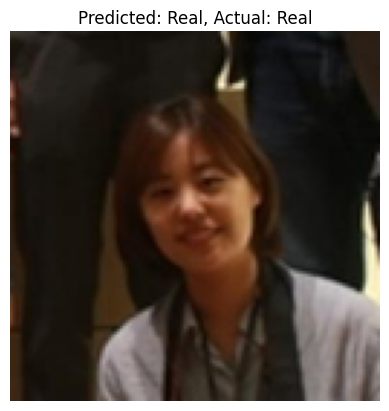

In [36]:
predict_random_image(unet_model, X_val, y_val)

#Support Vector Classifier

SVM Predicted Label: Fake
SVM Accuracy: 0.572
Actual Label: Fake


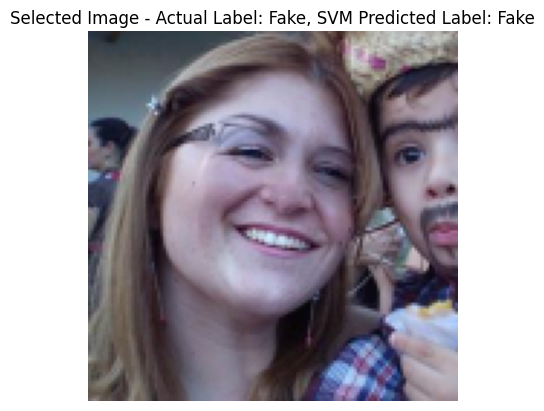

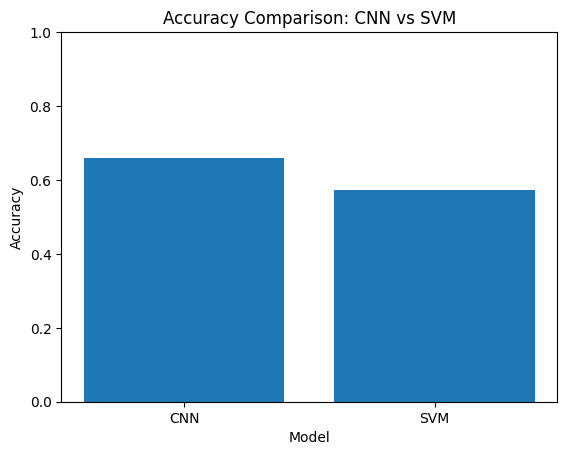

In [37]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extract_hog_features(images):
    hog_features = []
    winSize = (128, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    for img in images:
        h = hog.compute(img)
        hog_features.append(h.flatten())
    return np.array(hog_features)

def predict_image_svm(model, image):
    hog_feature = extract_hog_features([image])
    prediction = model.predict(hog_feature)
    return prediction

# Preprocess images for SVM
x_vals=[76,377,243,85,382,603]
X_train_svm = extract_hog_features(X_train)
X_val_svm = extract_hog_features(X_val)

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train)

# Select a random index from the validation set
random_index =random.choice(x_vals)
#random_index = random.randint(0, len(X_val) - 1)
selected_image = X_val[random_index]

# Predict using SVM model
svm_pred = predict_image_svm(svm_model, selected_image)

# Decode prediction
predicted_label_svm = "Real" if svm_pred[0] == 1 else "Fake"
print("SVM Predicted Label:", predicted_label_svm)

# Calculate accuracy of SVM model
svm_pred_val = svm_model.predict(X_val_svm)
svm_accuracy = accuracy_score(y_val, svm_pred_val)
print("SVM Accuracy:", svm_accuracy)

# Print actual label of the selected image
actual_label = "Real" if y_val[random_index] == 1 else "Fake"
print("Actual Label:", actual_label)

# Plot the selected image
plt.imshow(selected_image)
plt.title(f"Selected Image - Actual Label: {actual_label}, SVM Predicted Label: {predicted_label_svm}")
plt.axis('off')
plt.show()

# Plotting accuracy of CNN and SVM
plt.bar(["CNN", "SVM"], [val_acc, svm_accuracy])
plt.title("Accuracy Comparison: CNN vs SVM")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
